In [1]:
%matplotlib notebook
%load_ext autoreload

In [2]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pygalmesh
import fenics as fe
import fenics_adjoint as fa
import torch
import torch_fenics

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import sys
sys.path.append('..')
import project

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: dv001
--------------------------------------------------------------------------


In [3]:
case_name = 'Case1Pack'
ee_phase = 50
ei_phase = 0
lung_roi = 'lung_combined_mask'

In [4]:
ds = project.imaging.Emory4DCTDataset(
    data_root='../data/Emory-4DCT',
    case_names=[case_name],
    phases=[ei_phase, ee_phase]
)
ds.load_niftis()
ds.load_masks(roi=['lung_combined_mask', 'body'])
ds.load_displacements(fixed_phase=ee_phase)

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T00_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T50_T50.nii.gz


In [5]:
case = ds[0]

ee_anat_image = case.array.sel(phase=ee_phase)
ei_anat_image = case.array.sel(phase=ei_phase)

ee_lung_mask = case.mask.sel(phase=ee_phase, roi=lung_roi)
ei_lung_mask = case.mask.sel(phase=ei_phase, roi=lung_roi)

ee_overlay = (ee_lung_mask + 1) / 2
ei_overlay = (ei_lung_mask + 1) / 2

reg_disp_image = case.disp.sel(phase=0)

<IPython.core.display.Javascript object>


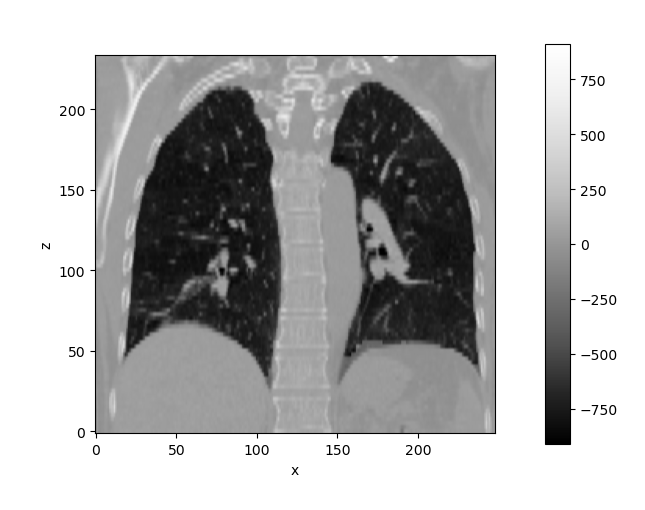

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


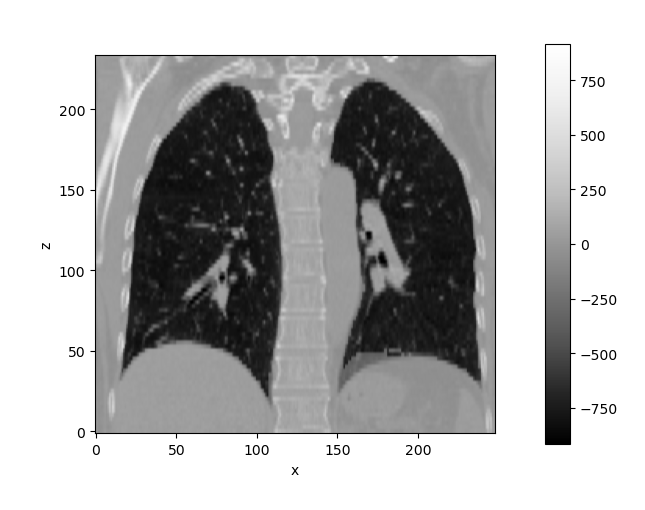

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [6]:
project.visual.view(ee_anat_image * ee_overlay, x='x', y='z', cmap='Greys_r')
project.visual.view(ei_anat_image * ei_overlay, x='x', y='z', cmap='Greys_r')

<IPython.core.display.Javascript object>


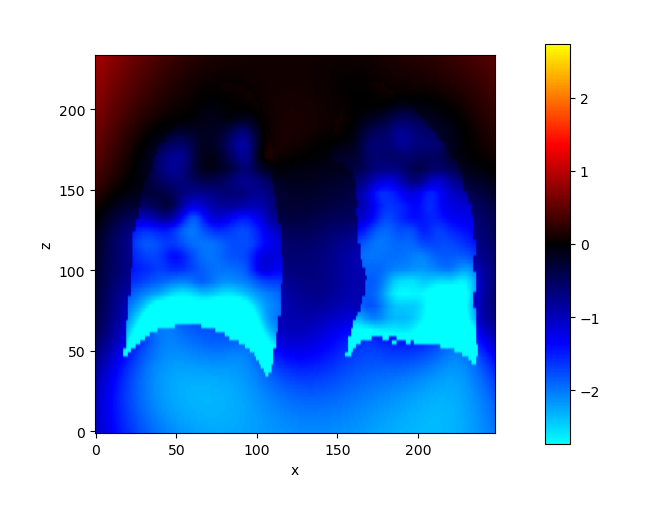

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [7]:
project.visual.view(reg_disp_image * ee_overlay, x='x', y='z')

<IPython.core.display.Javascript object>


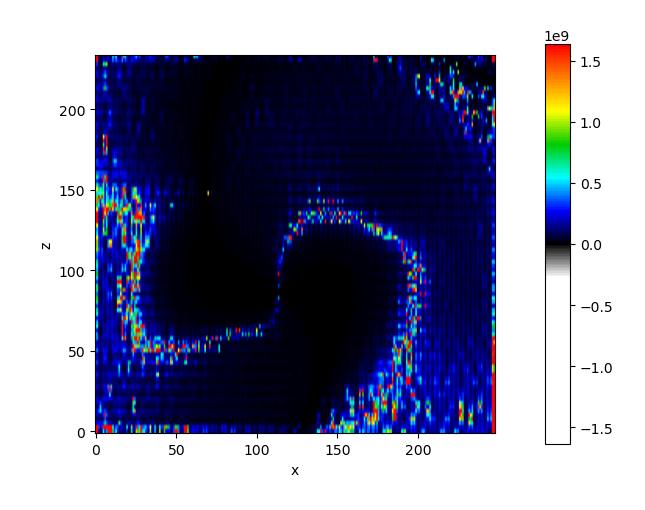

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [8]:
# direct inversion

dx_image = reg_disp_image.differentiate('x')
dy_image = reg_disp_image.differentiate('y')
dz_image = reg_disp_image.differentiate('z')

dxx_image = dx_image.differentiate('x')
dyy_image = dy_image.differentiate('y')
dzz_image = dz_image.differentiate('z')

laplacian_image = dxx_image + dyy_image + dzz_image

rho = 1000
omega = 2 * np.pi * 1
elast_image = -rho * omega**2 * (reg_disp_image.sum('component') / laplacian_image.sum('component'))
elast_image.name = 'elasticity'

project.visual.view(np.abs(elast_image) * ee_overlay, x='x', y='z', cmap=project.visual.mre_color_map())

In [263]:
%%time
ee_lung_mesh = pygalmesh.generate_from_array(
    ee_lung_mask.values.astype(np.uint16),
    voxel_size=case.resolution,
    max_cell_circumradius=5.0,
    odt=True
)

CPU times: user 5.46 s, sys: 24.9 ms, total: 5.49 s
Wall time: 5.97 s


In [264]:
%%time
vertices = ee_lung_mesh.points
facets = ee_lung_mesh.cells[0].data
tetras = ee_lung_mesh.cells[1].data

tetra_facets = np.concatenate([
    tetras[:,[0,1,2]],
    tetras[:,[0,1,3]],
    tetras[:,[0,2,3]],
    tetras[:,[1,2,3]],
    
    tetras[:,[2,1,0]],
    tetras[:,[3,1,0]],
    tetras[:,[3,2,0]],
    tetras[:,[3,2,1]],
])

#angles = project.meshing.compute_angles_to_interior(vertices, facets, tetras)
#tetra_angles = project.meshing.compute_angles_to_interior(vertices, tetra_facets, tetras)

vertices.shape, facets.shape, tetras.shape

CPU times: user 4.64 ms, sys: 885 µs, total: 5.52 ms
Wall time: 4.47 ms


((14068, 3), (19468, 3), (69594, 4))

<IPython.core.display.Javascript object>


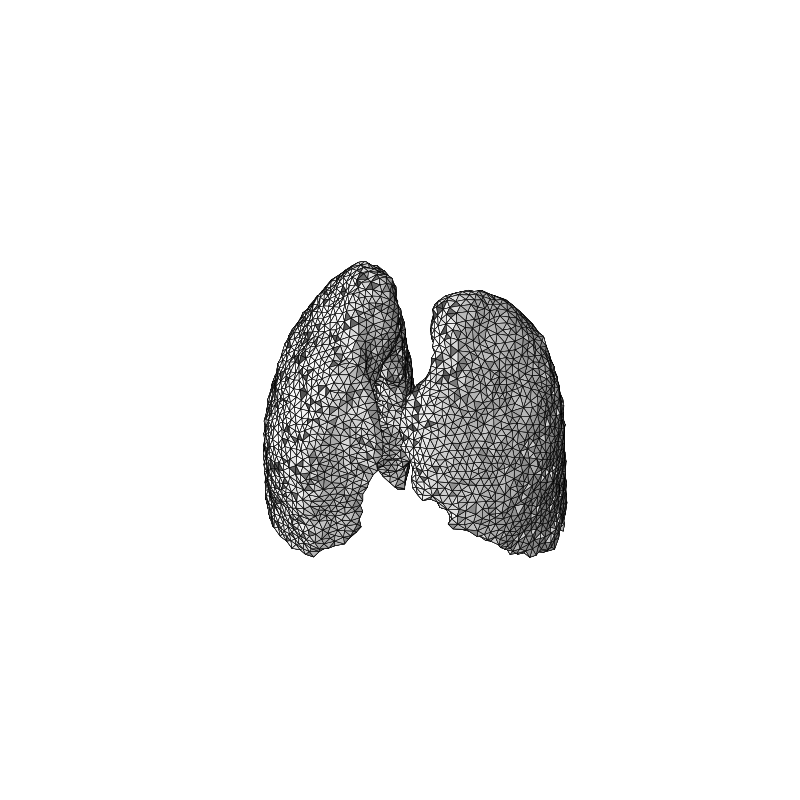

In [265]:
# view surface mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    facets, #[angles > 0],
    facecolors='white',
    edgecolors='black',
    shade=True,
    alpha=1.0,
    linewidth=0.4,
    figsize=(8,8)
)
ax.grid(False)
ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))
ax.set_axis_off()

<IPython.core.display.Javascript object>


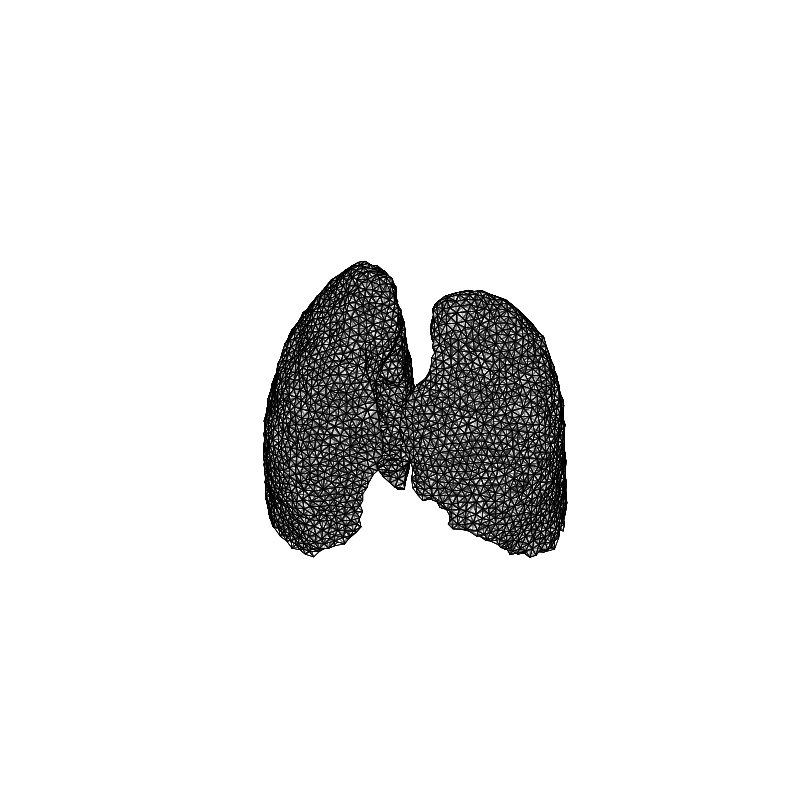

In [266]:
# view volume mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    tetra_facets,
    facecolors='white',
    edgecolors='black',
    alpha=0.1,
    linewidth=0.4,
    figsize=(8,8)
)
ax.grid(False)
ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))
ax.set_axis_off()

In [267]:
vertices.max(axis=0) - vertices.min(axis=0)

array([223.3338 , 149.38466, 194.84398], dtype=float32)

In [281]:
import nibabel as nib
import pygalmesh
import meshio
from mpi4py import MPI
import fenics as fe

def convert_to_fe_mesh(points, cells):
    '''
    Convert from meshio to fenics mesh.
    '''
    mesh_file = 'temp.xdmf'
    meshio.write_points_cells(mesh_file, points, [(cells.type, cells.data)])
    fe_mesh = fe.Mesh()
    with fe.XDMFFile(MPI.COMM_WORLD, mesh_file) as f:
        f.read(fe_mesh)
    return fe_mesh

nifti = nib.load('lung_combined_mask.nii.gz')
max_radius = 5.0 # try 10.0, 20.0

mesh = pygalmesh.generate_from_array(
    nifti.get_fdata().astype(np.uint16),
    voxel_size=nifti.header.get_zooms(),
    max_cell_circumradius=max_radius,
    odt=True
)
fe_mesh = convert_to_fe_mesh(mesh.points, mesh.cells[1])
fe_space = fe.FunctionSpace(fe_mesh, 'P', 1)

v1 = [tuple(v) for v in mesh.points]
v2 = [tuple(v) for v in fe_mesh.coordinates()]
v3 = [tuple(v) for v in fe_space.tabulate_dof_coordinates()]

assert set(v1) == set(v2), (set(v1) - set(v2), set(v2) - set(v1))
assert set(v1) == set(v3), (set(v1) - set(v3), set(v3) - set(v1))

AssertionError: ({(169.13596, 130.50793, 130.2164), (97.680405, 161.96782, 28.77537)}, {(0.0, 0.0, 0.0)})

In [269]:
case.mask_dir

PosixPath('../data/Emory-4DCT/Case1Pack/TotalSegment')

In [173]:
%%time
u_tensor = torch.as_tensor(reg_disp_image.values)
print(u_tensor.shape)

ee_lung_fe_mesh = convert_to_fe_mesh(ee_lung_mesh.points, ee_lung_mesh.cells[1])
u_func_space = fe.VectorFunctionSpace(ee_lung_fe_mesh, 'P', 1)
u_func_dofs = project.interpolate.image_to_dofs(u_tensor, case.resolution, u_func_space)
print(u_func_dofs.shape)

torch.Size([256, 256, 94, 3])
torch.Size([2013, 3])
CPU times: user 25.9 ms, sys: 24.9 ms, total: 50.8 ms
Wall time: 2.63 s


In [174]:
%%time
u_interp = project.interpolate.dofs_to_image(u_func_dofs, u_func_space, case.shape, case.resolution)
print(u_interp.shape)

(256, 256, 94) (256, 256, 94, 3)
(256, 256, 94, 3)
CPU times: user 1min 46s, sys: 145 ms, total: 1min 46s
Wall time: 1min 47s


<IPython.core.display.Javascript object>


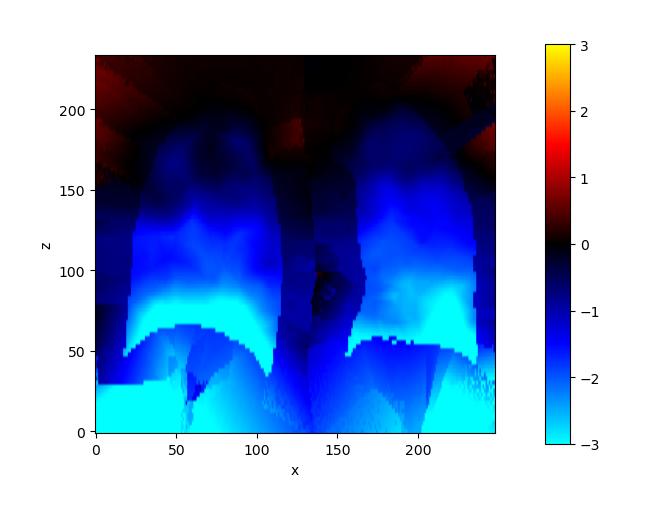

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


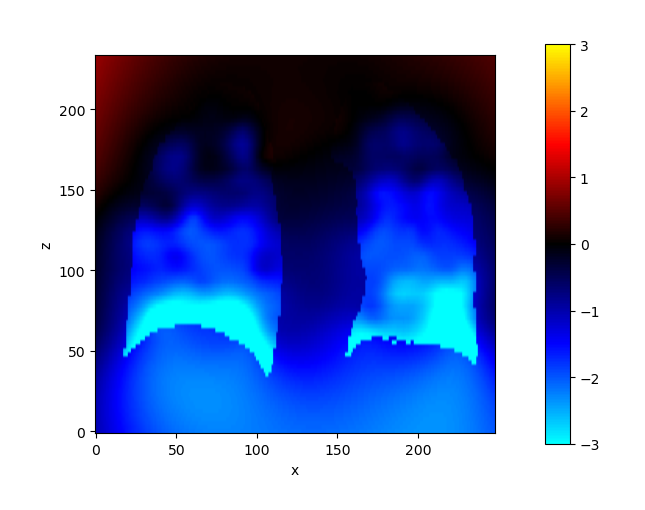

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [175]:
project.visual.XArrayViewer((reg_disp_image * 0 + u_interp) * ee_overlay, x='x', y='z', vmin=-3, vmax=3)
project.visual.XArrayViewer(reg_disp_image * ee_overlay, x='x', y='z', vmin=-3, vmax=3)

## Physical model

Conservation of momentum
$$
    \nabla\cdot\sigma + \mathbf{b} = 0
$$

Isotropic linear elasticity
$$
    \sigma = 2 \mu \epsilon + \lambda \operatorname{tr}(\epsilon) \mathbf{I}
$$

Strain-displacement relation
$$
    \epsilon = \tfrac{1}{2} \left( \nabla \mathbf{u} + \nabla \mathbf{u}^\top \right)
$$

Weak formulation
$$
\begin{align*}
    \nabla\cdot\sigma + \mathbf{b} &= 0 \\
    -\nabla\cdot\sigma &= \mathbf{b} \\
    -\int_\Omega (\nabla\cdot\sigma)\cdot\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} \\
    \int_\Omega \sigma\cdot\nabla\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} (\sigma\cdot\mathbf{n})\cdot\mathbf{v} \,d\mathbf{s} \\
    \int_\Omega \sigma(\mathbf{u})\cdot\epsilon(\mathbf{v}) \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} \mathbf{t}\cdot\mathbf{v} \,d\mathbf{s}
\end{align*}
$$



In [177]:
%%time
class PDESolver(torch_fenics.FEniCSModule):

    def __init__(self, mesh):
        super().__init__()
        
        # initialize function spaces
        self.scalar_space = fe.FunctionSpace(mesh, 'P', 1)
        self.vector_space = fe.VectorFunctionSpace(mesh, 'P', 1)
            
    def input_templates(self):
        return (
            fa.Function(self.vector_space), # u_true
            fa.Function(self.scalar_space), # mu
        )

    def solve(self, u_true, mu):

        # define physical parameters
        g   = 9.8 # gravitational acceleration (m/s^2)
        rho = 1.0 # mass density (kg/m^3)
        nu  = 0.4 # Poisson's ratio (unitless)
    
        lam = 2*mu*nu/(1 - 2*nu) # Lame's first parameter (Pa)

        # set displacement boundary condition
        u_bc = fa.DirichletBC(self.vector_space, u_true, 'on_boundary')

        # body force and traction
        b = fa.Constant((0, 0, -rho * g))
        t = fa.Constant((0, 0, 0))

        # define stress and strain
        def epsilon(u):
            return (fe.grad(u) + fe.grad(u).T) / 2

        def sigma(u):
            I = fe.Identity(u.geometric_dimension())
            return lam * fe.div(u) * I + 2 * mu * epsilon(u)

        # weak PDE formulation
        u = fe.TrialFunction(self.vector_space)
        v = fe.TestFunction(self.vector_space)

        a = fe.inner(sigma(u), epsilon(v)) * fe.dx
        L = fe.dot(b, v) * fe.dx + fe.dot(t, v) * fe.ds

        # solve for displacement
        u_pred = fa.Function(self.vector_space)
        fa.solve(a == L, u_pred, u_bc)

        return u_pred

pde_solver = PDESolver(ee_lung_fe_mesh)

u_tensor = torch.as_tensor(reg_disp_image.values)
mu_tensor = torch.randn(case.shape, dtype=torch.float64)*0 + 3e3

u_func_dofs = project.interpolate.image_to_dofs(u_tensor, case.resolution, pde_solver.vector_space)
u_func_dofs.requires_grad = False

mu_func_dofs = project.interpolate.image_to_dofs(mu_tensor, case.resolution, pde_solver.scalar_space)
mu_func_dofs.requires_grad = True

u_pred_func_dofs = pde_solver.forward(u_func_dofs.unsqueeze(0), mu_func_dofs.unsqueeze(0))[0]

CPU times: user 670 ms, sys: 1.19 s, total: 1.86 s
Wall time: 2.88 s


In [178]:
(u_pred_func_dofs.isnan()).sum().item()

3

In [157]:
L = F.mse_loss(u_pred_func_dofs, u_func_dofs)
print(L)
L.backward()
print(u_func_dofs.grad)
print(mu_func_dofs.grad)

tensor(0.0611, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
None
tensor([ 0.0000e+00, -5.5000e-08, -2.5433e-08, -1.3770e-08, -3.1522e-08,
        -9.5263e-09,  1.0452e-09,  0.0000e+00, -3.0542e-08, -8.5720e-08,
        -7.5771e-08,  8.2155e-08,  9.2987e-08,  1.8436e-07, -3.1916e-08,
        -4.2884e-08, -2.8772e-09, -4.2198e-08, -2.3293e-09, -7.4793e-08,
        -1.3414e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.2237e-08,
        -7.8975e-09,  4.4193e-08, -6.3676e-08, -6.6033e-08,  9.5351e-08,
         4.4901e-07,  1.4100e-07, -7.0522e-08,  1.0564e-07,  2.0124e-07,
         1.8115e-07,  1.6279e-07,  4.5789e-08, -2.7516e-09, -1.1654e-08,
        -1.3645e-07, -6.7870e-08, -4.8105e-08, -1.4618e-07, -2.6256e-07,
        -1.5674e-07, -9.5432e-08, -1.4322e-08, -7.2920e-08,  1.1641e-08,
   

In [158]:
import torch.nn.functional as F
from torch import optim

mu_func_dofs.requires_grad = True

optimizer = optim.Adam([mu_func_dofs], lr=5e-1)

for i in range(10000):
    optimizer.zero_grad()

    u_pred_func_dofs = pde_solver.forward(u_func_dofs.unsqueeze(0), mu_func_dofs.unsqueeze(0))[0]

    loss = F.mse_loss(u_pred_func_dofs, u_func_dofs)
    print((i+1), loss.item())

    loss.backward()
    optimizer.step()


1 0.06112361950044231
2 0.06111270409255078
3 0.061101791383462875
4 0.06109088141600713
5 0.06107997423269653
6 0.06106906987563395
7 0.061058168386419705
8 0.06104726980606268
9 0.061036374174896206
10 0.06102548153249814
11 0.06101459191761651
12 0.0610037053681004
13 0.06099282192083768
14 0.06098194161169828
15 0.060971064475484164
16 0.06096019054588639
17 0.06094931985544821
18 0.06093845243553494
19 0.06092758831631096
20 0.06091672752672193
21 0.0609058700944842
22 0.060895016046079734
23 0.06088416540675621
24 0.060873318200533086
25 0.06086247445021161
26 0.06085163417739009
27 0.060840797402482764
28 0.060829964144742406
29 0.060819134422286085
30 0.060808308252123626
31 0.060797485650189026
32 0.060786666631373026
33 0.06077585120955811
34 0.060765039397654444
35 0.060754231207636525
36 0.06074342665058108
37 0.06073262573670504
38 0.06072182847540348
39 0.060711034875287714
40 0.060700244944223006
41 0.06068945868936585
42 0.060678676117200125
43 0.06066789723357323
44 0.

343 0.05759241060460533
344 0.057582647697463414
345 0.057572887796016214
346 0.05756313089806289
347 0.05755337700140496
348 0.05754362610384652
349 0.057533878203193965
350 0.057524133297256246
351 0.057514391383844815
352 0.05750465246077341
353 0.05749491652585835
354 0.05748518357691836
355 0.05747545361177454
356 0.05746572662825044
357 0.05745600262417215
358 0.057446281597368004
359 0.057436563545668964
360 0.0574268484669082
361 0.05741713635892143
362 0.0574074272195468
363 0.05739772104662474
364 0.05738801783799827
365 0.05737831759151263
366 0.057368620305015564
367 0.057358925976357174
368 0.05734923460339001
369 0.05733954618396895
370 0.05732986071595131
371 0.057320178197196765
372 0.05731049862556733
373 0.05730082199892746
374 0.05729114831514398
375 0.057281477572086084
376 0.05727180976762528
377 0.05726214489963553
378 0.057252482965993154
379 0.057242823964576625
380 0.05723316789326712
381 0.05722351474994785
382 0.05721386453250466
383 0.05720421723882548
384 0

684 0.054424331975850254
685 0.05441548090472662
686 0.0544066322125135
687 0.054397785897688226
688 0.05438894195872974
689 0.05438010039411872
690 0.05437126120233724
691 0.05436242438186901
692 0.054353589931199396
693 0.05434475784881521
694 0.05433592813320493
695 0.05432710078285857
696 0.05431827579626777
697 0.05430945317192562
698 0.05430063290832686
699 0.0542918150039678
700 0.054282999457346305
701 0.05427418626696178
702 0.054265375431315176
703 0.054256566948909034
704 0.0542477608182474
705 0.05423895703783594
706 0.05423015560618186
707 0.054221356521793794
708 0.05421255978318207
709 0.05420376538885853
710 0.05419497333733651
711 0.05418618362713094
712 0.054177396256758166
713 0.05416861122473622
714 0.05415982852958462
715 0.05415104816982439
716 0.054142270143978086
717 0.05413349445056977
718 0.05412472108812516
719 0.054115950055171315
720 0.05410718135023696
721 0.05409841497185221
722 0.05408965091854884
723 0.05408088918886001
724 0.05407212978132052
725 0.054

1025 0.05153485553052209
1026 0.05152673676240766
1027 0.05151861993405458
1028 0.051510505044380255
1029 0.05150239209230315
1030 0.05149428107674263
1031 0.051486171996619326
1032 0.051478064850854655
1033 0.051469959638371296
1034 0.05146185635809285
1035 0.051453755008943856
1036 0.051445655589850155
1037 0.05143755809973833
1038 0.051429462537536136
1039 0.0514213689021724
1040 0.051413277192576864
1041 0.05140518740768043
1042 0.05139709954641483
1043 0.05138901360771308
1044 0.05138092959050894
1045 0.051372847493737356
1046 0.0513647673163343
1047 0.051356689057236754
1048 0.05134861271538271
1049 0.051340538289711066
1050 0.05133246577916187
1051 0.051324395182676195
1052 0.05131632649919601
1053 0.051308259727664424
1054 0.05130019486702544
1055 0.051292131916224185
1056 0.05128407087420672
1057 0.05127601173992013
1058 0.0512679545123125
1059 0.05125989919033294
1060 0.051251845772931556
1061 0.05124379425905948
1062 0.05123574464766876
1063 0.051227696937712536
1064 0.05121

1350 0.04899268973424115
1351 0.04898514978971522
1352 0.048977611481849884
1353 0.048970074809846796
1354 0.048962539772908376
1355 0.04895500637023784
1356 0.04894747460103903
1357 0.048939944464516646
1358 0.048932415959876026
1359 0.048924889086323246
1360 0.04891736384306518
1361 0.048909840229309304
1362 0.04890231824426392
1363 0.04889479788713803
1364 0.0488872791571414
1365 0.04887976205348444
1366 0.04887224657537836
1367 0.04886473272203503
1368 0.0488572204926671
1369 0.04884970988648789
1370 0.0488422009027115
1371 0.0488346935405527
1372 0.048827187799227026
1373 0.048819683677950663
1374 0.048812181175940585
1375 0.04880468029241449
1376 0.04879718102659074
1377 0.04878968337768841
1378 0.0487821873449273
1379 0.04877469292752797
1380 0.048767200124711675
1381 0.048759708935700384
1382 0.0487522193597167
1383 0.04874473139598408
1384 0.0487372450437266
1385 0.048729760302168974
1386 0.04872227717053691
1387 0.04871479564805644
1388 0.04870731573395461
1389 0.048699837427

1676 0.04661712060808011
1677 0.04661007580196308
1678 0.046603032407241306
1679 0.046595990423320854
1680 0.04658894984960846
1681 0.046581910685511305
1682 0.046574872930437196
1683 0.04656783658379432
1684 0.04656080164499156
1685 0.04655376811343821
1686 0.04654673598854418
1687 0.04653970526971987
1688 0.0465326759563762
1689 0.04652564804792467
1690 0.046518621543777255
1691 0.04651159644334647
1692 0.046504572746045365
1693 0.046497550451287534
1694 0.04649052955848707
1695 0.046483510067058684
1696 0.04647649197641742
1697 0.04646947528597904
1698 0.046462459995159786
1699 0.04645544610337631
1700 0.04644843361004596
1701 0.04644142251458646
1702 0.04643441281641615
1703 0.0464274045149539
1704 0.04642039760961903
1705 0.04641339209983144
1706 0.04640638798501146
1707 0.04639938526458014
1708 0.04639238393795885
1709 0.046385384004569576
1710 0.046378385463834756
1711 0.04637138831517742
1712 0.04636439255802113
1713 0.0463573981917899
1714 0.046350405215908295
1715 0.046343413

2001 0.044398732350462954
2002 0.044392117798508934
2003 0.044385504490479996
2004 0.04437889242593224
2005 0.04437228160442214
2006 0.04436567202550673
2007 0.04435906368874323
2008 0.0443524565936894
2009 0.044345850739903256
2010 0.044339246126943364
2011 0.04433264275436858
2012 0.04432604062173815
2013 0.04431943972861177
2014 0.04431284007454949
2015 0.04430624165911173
2016 0.04429964448185934
2017 0.044293048542353546
2018 0.04428645384015595
2019 0.044279860374828554
2020 0.04427326814593376
2021 0.04426667715303437
2022 0.044260087395693475
2023 0.044253498873474705
2024 0.04424691158594197
2025 0.044240325532659615
2026 0.04423374071319231
2027 0.04422715712710517
2028 0.04422057477396372
2029 0.044213993653333845
2030 0.04420741376478173
2031 0.04420083510787408
2032 0.04419425768217784
2033 0.04418768148726049
2034 0.04418110652268986
2035 0.044174532788034036
2036 0.044167960282861615
2037 0.04416138900674154
2038 0.04415481895924311
2039 0.04414825013993607
2040 0.044141

2326 0.04231214930528095
2327 0.04230591774030881
2328 0.04229968729391012
2329 0.04229345796575287
2330 0.04228722975550534
2331 0.04228100266283616
2332 0.042274776687414195
2333 0.04226855182890866
2334 0.042262328086989064
2335 0.04225610546132519
2336 0.04224988395158716
2337 0.04224366355744543
2338 0.04223744427857065
2339 0.04223122611463394
2340 0.04222500906530659
2341 0.04221879313026019
2342 0.04221257830916675
2343 0.04220636460169839
2344 0.04220015200752777
2345 0.042193940526327696
2346 0.042187730157771317
2347 0.042181520901532064
2348 0.04217531275728367
2349 0.042169105724700215
2350 0.04216289980345605
2351 0.04215669499322585
2352 0.04215049129368453
2353 0.04214428870450739
2354 0.04213808722536996
2355 0.042131886855948104
2356 0.042125687595918004
2357 0.0421194894449561
2358 0.04211329240273914
2359 0.042107096468944234
2360 0.042100901643248714
2361 0.04209470792533024
2362 0.042088515314866765
2363 0.042082323811536565
2364 0.04207613341501823
2365 0.0420699

2653 0.04033226996884575
2654 0.0403263881801934
2655 0.040320507417100214
2656 0.04031462767932843
2657 0.04030874896664047
2658 0.04030287127879906
2659 0.04029699461556721
2660 0.04029111897670824
2661 0.040285244361985766
2662 0.0402793707711636
2663 0.040273498204005914
2664 0.04026762666027717
2665 0.04026175613974207
2666 0.04025588664216556
2667 0.040250018167313016
2668 0.04024415071494998
2669 0.04023828428484227
2670 0.04023241887675605
2671 0.04022655449045773
2672 0.040220691125714025
2673 0.04021482878229195
2674 0.04020896745995871
2675 0.04020310715848193
2676 0.040197247877629426
2677 0.04019138961716928
2678 0.040185532376869976
2679 0.040179676156500164
2680 0.04017382095582883
2681 0.04016796677462524
2682 0.040162113612658944
2683 0.0401562614696998
2684 0.04015041034551782
2685 0.04014456023988349
2686 0.04013871115256753
2687 0.04013286308334085
2688 0.040127016031974716
2689 0.04012116999824067
2690 0.04011532498191056
2691 0.04010948098275649
2692 0.04010363800

2979 0.038467908627527206
2980 0.038462350236123585
2981 0.038456792808337775
2982 0.03845123634403026
2983 0.038445680843061866
2984 0.03844012630529371
2985 0.03843457273058726
2986 0.03842902011880429
2987 0.03842346846980684
2988 0.0384179177834574
2989 0.03841236805961872
2990 0.03840681929815382
2991 0.03840127149892612
2992 0.03839572466179938
2993 0.038390178786637544
2994 0.038384633873305096
2995 0.03837908992166663
2996 0.038373546931587205
2997 0.03836800490293216
2998 0.03836246383556711
2999 0.038356923729358124
3000 0.038351384584171457
3001 0.038345846399873776
3002 0.03834030917633202
3003 0.03833477291341352
3004 0.038329237610985833
3005 0.03832370326891693
3006 0.03831816988707504
3007 0.03831263746532881
3008 0.03830710600354711
3009 0.03830157550159916
3010 0.03829604595935458
3011 0.03829051737668322
3012 0.038284989753455324
3013 0.038279463089541395
3014 0.03827393738481233
3015 0.038268412639139306
3016 0.03826288885239381
3017 0.038257366024447764
3018 0.0382

3305 0.036706273150884754
3306 0.0367010233734221
3307 0.03669577453132431
3308 0.03669052662455678
3309 0.03668527965308511
3310 0.0366800336168753
3311 0.03667478851589362
3312 0.036669544350106546
3313 0.03666430111948095
3314 0.036659058823984056
3315 0.036653817463583274
3316 0.03664857703824632
3317 0.03664333754794129
3318 0.03663809899263653
3319 0.03663286137230069
3320 0.03662762468690268
3321 0.036622388936411794
3322 0.036617154120797524
3323 0.03661192024002978
3324 0.03660668729407864
3325 0.0366014552829145
3326 0.03659622420650818
3327 0.03659099406483066
3328 0.03658576485785323
3329 0.03658053658554755
3330 0.036575309247885504
3331 0.03657008284483935
3332 0.03656485737638151
3333 0.036559632842484834
3334 0.0365544092431224
3335 0.03654918657826755
3336 0.036543964847894024
3337 0.036538744051975776
3338 0.03653352419048701
3339 0.036528305263402325
3340 0.0365230872706966
3341 0.036517870212344886
3342 0.03651265408832268
3343 0.03650743889860572
3344 0.03650222464

3633 0.03503443780696281
3634 0.03502949455100748
3635 0.035024552232877725
3636 0.03501961085261363
3637 0.03501467041025532
3638 0.03500973090584314
3639 0.03500479233941747
3640 0.034999854711018845
3641 0.034994918020687917
3642 0.03498998226846547
3643 0.034985047454392355
3644 0.03498011357850961
3645 0.0349751806408583
3646 0.034970248641479657
3647 0.034965317580415024
3648 0.034960387457705855
3649 0.034955458273393705
3650 0.03495053002752022
3651 0.0349456027201272
3652 0.0349406763512565
3653 0.034935750920950144
3654 0.0349308264292502
3655 0.03492590287619887
3656 0.034920980261838465
3657 0.03491605858621137
3658 0.03491113784936014
3659 0.034906218051327355
3660 0.03490129919215573
3661 0.0348963812718881
3662 0.03489146429056736
3663 0.03488654824823651
3664 0.034881633144938654
3665 0.03487671898071701
3666 0.0348718057556149
3667 0.03486689346967567
3668 0.03486198212294286
3669 0.03485707171545996
3670 0.0348521622472707
3671 0.03484725371841891
3672 0.0348423461289

3960 0.033468240163528694
3961 0.03346360597412384
3962 0.03345897273662688
3963 0.0334543404510659
3964 0.033449709117468696
3965 0.033445078735862964
3966 0.03344044930627614
3967 0.033435820828735405
3968 0.03343119330326781
3969 0.03342656672990015
3970 0.033421941108659016
3971 0.0334173164395708
3972 0.03341269272266162
3973 0.03340806995795746
3974 0.03340344814548407
3975 0.0333988272852669
3976 0.03339420737733135
3977 0.03338958842170237
3978 0.03338497041840492
3979 0.03338035336746353
3980 0.033375737268902694
3981 0.03337112212274658
3982 0.03336650792901911
3983 0.03336189468774405
3984 0.0333572823989449
3985 0.03335267106264495
3986 0.03334806067886718
3987 0.033343451247634555
3988 0.0333388427689695
3989 0.03333423524289448
3990 0.03332962866943156
3991 0.03332502304860268
3992 0.033320418380429435
3993 0.03331581466493325
3994 0.033311211902135304
3995 0.0333066100920566
3996 0.03330200923471778
3997 0.0332974093301393
3998 0.03329281037834139
3999 0.0332882123793440

4288 0.03199930969633162
4289 0.03199498756092688
4290 0.03199066636984921
4291 0.03198634612300855
4292 0.03198202682031421
4293 0.03197770846167515
4294 0.03197339104699973
4295 0.031969074576195904
4296 0.03196475904917111
4297 0.03196044446583238
4298 0.03195613082608609
4299 0.03195181812983825
4300 0.031947506376994374
4301 0.0319431955674595
4302 0.03193888570113811
4303 0.03193457677793428
4304 0.031930268797751495
4305 0.0319259617604929
4306 0.03192165566606101
4307 0.031917350514357914
4308 0.03191304630528523
4309 0.03190874303874402
4310 0.03190444071463488
4311 0.031900139332858006
4312 0.03189583889331293
4313 0.03189153939589882
4314 0.03188724084051436
4315 0.03188294322705762
4316 0.03187864655542632
4317 0.03187435082551758
4318 0.03187005603722807
4319 0.031865762190454
4320 0.03186146928509099
4321 0.03185717732103426
4322 0.03185288629817849
4323 0.03184859621641784
4324 0.03184430707564605
4325 0.03184001887575629
4326 0.03183573161664127
4327 0.03183144529819319

4611 0.030651643618151474
4612 0.03064761902424669
4613 0.030643595319513266
4614 0.030639572503701622
4615 0.030635550576561744
4616 0.03063152953784318
4617 0.030627509387295023
4618 0.03062349012466593
4619 0.030619471749704093
4620 0.030615454262157362
4621 0.030611437661773034
4622 0.030607421948298002
4623 0.030603407121478753
4624 0.03059939318106136
4625 0.030595380126791347
4626 0.030591367958413926
4627 0.030587356675673794
4628 0.03058334627831526
4629 0.030579336766082186
4630 0.030575328138718008
4631 0.030571320395965704
4632 0.030567313537567864
4633 0.030563307563266594
4634 0.030559302472803647
4635 0.030555298265920256
4636 0.03055129494235731
4637 0.030547292501855217
4638 0.03054329094415395
4639 0.030539290268993102
4640 0.030535290476111844
4641 0.030531291565248867
4642 0.03052729353614246
4643 0.03052329638853053
4644 0.030519300122150487
4645 0.030515304736739426
4646 0.030511310232033892
4647 0.030507316607770115
4648 0.030503323863683846
4649 0.03049933199951

4932 0.029403882965962934
4933 0.02940012890540159
4934 0.029396375635657904
4935 0.029392623156384832
4936 0.029388871467235123
4937 0.029385120567861387
4938 0.029381370457916126
4939 0.02937762113705169
4940 0.029373872604920307
4941 0.02937012486117412
4942 0.029366377905465015
4943 0.02936263173744483
4944 0.0293588863567653
4945 0.029355141763077956
4946 0.029351397956034263
4947 0.02934765493528555
4948 0.029343912700482946
4949 0.029340171251277546
4950 0.029336430587320318
4951 0.02933269070826206
4952 0.02932895161375345
4953 0.02932521330344509
4954 0.02932147577698742
4955 0.0293177390340308
4956 0.02931400307422543
4957 0.029310267897221444
4958 0.0293065335026688
4959 0.029302799890217415
4960 0.029299067059517025
4961 0.029295335010217298
4962 0.029291603741967768
4963 0.029287873254417875
4964 0.02928414354721697
4965 0.029280414620014256
4966 0.029276686472458836
4967 0.029272959104199706
4968 0.029269232514885807
4969 0.02926550670416593
4970 0.02926178167168876
4971 

5255 0.028230481784615565
5256 0.02822696476852431
5257 0.028223448428981092
5258 0.02821993276563483
5259 0.02821641777813435
5260 0.02821290346612849
5261 0.02820938982926617
5262 0.028205876867196285
5263 0.02820236457956773
5264 0.028198852966029395
5265 0.02819534202623025
5266 0.028191831759819166
5267 0.028188322166445123
5268 0.02818481324575705
5269 0.028181304997403882
5270 0.02817779742103454
5271 0.028174290516298037
5272 0.02817078428284326
5273 0.028167278720319208
5274 0.028163773828374847
5275 0.02816026960665907
5276 0.028156766054820866
5277 0.028153263172509203
5278 0.028149760959372983
5279 0.028146259415061162
5280 0.02814275853922268
5281 0.02813925833150647
5282 0.028135758791561428
5283 0.028132259919036465
5284 0.028128761713580495
5285 0.0281252641748424
5286 0.02812176730247106
5287 0.028118271096115345
5288 0.02811477555542409
5289 0.028111280680046143
5290 0.028107786469630275
5291 0.028104292923825363
5292 0.028100800042280133
5293 0.02809730782464334
5294

5576 0.0271343161196756
5577 0.02713099764050946
5578 0.027127679716326306
5579 0.027124362346672995
5580 0.027121045531095574
5581 0.027117729269139176
5582 0.027114413560348122
5583 0.02711109840426582
5584 0.027107783800434836
5585 0.02710446974839687
5586 0.02710115624769274
5587 0.02709784329786234
5588 0.027094530898444685
5589 0.027091219048977967
5590 0.027087907748999378
5591 0.027084596998045295
5592 0.027081286795651117
5593 0.027077977141351378
5594 0.027074668034679686
5595 0.02707135947516871
5596 0.027068051462350223
5597 0.027064743995755064
5598 0.027061437074913108
5599 0.027058130699353294
5600 0.02705482486860368
5601 0.027051519582191295
5602 0.027048214839642266
5603 0.02704491064048172
5604 0.0270416069842339
5605 0.027038303870421988
5606 0.027035001298568236
5607 0.027031699268193935
5608 0.027028397778819425
5609 0.02702509682996396
5610 0.027021796421145897
5611 0.02701849655188255
5612 0.027015197221690254
5613 0.02701189843008435
5614 0.027008600176579134
5

5896 0.026097783476884632
5897 0.026094612805389217
5898 0.02609144247438833
5899 0.026088272482910776
5900 0.026085102829983126
5901 0.026081933514629483
5902 0.026078764535871685
5903 0.02607559589272918
5904 0.02607242758421907
5905 0.026069259609356098
5906 0.026066091967152576
5907 0.026062924656618545
5908 0.02605975767676162
5909 0.02605659102658703
5910 0.02605342470509766
5911 0.026050258711293964
5912 0.026047093044174064
5913 0.026043927702733644
5914 0.02604076268596604
5915 0.026037597992862156
5916 0.026034433622410542
5917 0.02603126957359728
5918 0.02602810584540611
5919 0.026024942436818327
5920 0.026021779346812855
5921 0.026018616574366125
5922 0.026015454118452245
5923 0.026012291978042855
5924 0.026009130152107176
5925 0.026005968639612013
5926 0.026002807439521734
5927 0.025999646550798297
5928 0.025996485972401184
5929 0.0259933257032875
5930 0.025990165742411808
5931 0.02598700608872638
5932 0.02598384674118092
5933 0.025980687698722752
5934 0.025977528960296682

6216 0.02509423946627671
6217 0.025091114945452495
6218 0.025087990332280413
6219 0.02508486562510352
6220 0.025081740822264356
6221 0.025078615922104978
6222 0.02507549092296701
6223 0.025072365823191656
6224 0.025069240621119714
6225 0.025066115315091616
6226 0.025062989903447467
6227 0.02505986438452706
6228 0.025056738756669906
6229 0.02505361301821524
6230 0.02505048716750209
6231 0.025047361202869326
6232 0.025044235122655578
6233 0.025041108925199385
6234 0.025037982608839188
6235 0.02503485617191332
6236 0.025031729612760092
6237 0.02502860292971782
6238 0.02502547612112479
6239 0.025022349185319367
6240 0.025019222120639992
6241 0.025016094925425236
6242 0.025012967598013792
6243 0.02500984013674452
6244 0.025006712539956556
6245 0.025003584805989187
6246 0.02500045693318208
6247 0.02499732891987515
6248 0.024994200764408663
6249 0.024991072465123325
6250 0.024987944020360177
6251 0.02498481542846077
6252 0.024981686687767138
6253 0.024978557796621847
6254 0.02497542875336799


6537 0.02407860376232629
6538 0.02407538605522747
6539 0.02407216807165421
6540 0.024068949814609136
6541 0.024065731287146046
6542 0.024062512492370364
6543 0.024059293433439613
6544 0.024056074113563954
6545 0.024052854536006495
6546 0.024049634704083837
6547 0.024046414621166613
6548 0.02404319429067979
6549 0.02403997371610333
6550 0.024036752900972496
6551 0.024033531848878433
6552 0.02403031056346864
6553 0.02402708904844742
6554 0.024023867307576375
6555 0.02402064534467498
6556 0.02401742316362087
6557 0.024014200768350594
6558 0.024010978162859912
6559 0.024007755351204394
6560 0.02400453233749994
6561 0.024001309125923166
6562 0.02399808572071205
6563 0.023994862126166406
6564 0.0239916383466483
6565 0.023988414386582745
6566 0.02398519025045805
6567 0.023981965942826464
6568 0.023978741468304598
6569 0.02397551683157409
6570 0.023972292037381986
6571 0.023969067090541345
6572 0.023965841995931804
6573 0.023962616758500015
6574 0.023959391383260326
6575 0.02395616587529519
65

6857 0.02308552665822213
6858 0.023082817224738986
6859 0.023080112262058132
6860 0.023077411778807167
6861 0.02307471578323777
6862 0.023072024283222414
6863 0.02306933728625136
6864 0.02306665479942976
6865 0.023063976829474742
6866 0.023061303382712756
6867 0.023058634465076975
6868 0.023055970082104804
6869 0.023053310238935573
6870 0.023050654940308297
6871 0.023048004190559582
6872 0.023045357993621722
6873 0.02304271635302078
6874 0.023040079271875034
6875 0.023037446752893365
6876 0.023034818798373834
6877 0.023032195410202468
6878 0.023029576589852177
6879 0.02302696233838173
6880 0.023024352656434953
6881 0.0230217475442401
6882 0.023019147001609352
6883 0.02301655102793839
6884 0.02301395962220626
6885 0.023011372782975343
6886 0.023008790508391407
6887 0.023006212796183922
6888 0.023003639643666536
6889 0.02300107104773756
6890 0.022998507004880826
6891 0.022995947511166574
6892 0.022993392562252513
6893 0.022990842153385115
6894 0.02298829627940097
6895 0.02298575493472839

7177 0.02238776935052262
7178 0.022385881177306558
7179 0.0223839939006993
7180 0.022382107517403153
7181 0.022380222024150742
7182 0.022378337417704803
7183 0.022376453694857728
7184 0.022374570852431316
7185 0.02237268888727643
7186 0.022370807796272717
7187 0.022368927576328263
7188 0.02236704822437931
7189 0.02236516973738991
7190 0.0223632921123517
7191 0.022361415346283525
7192 0.0223595394362312
7193 0.022357664379267242
7194 0.022355790172490494
7195 0.02235391681302594
7196 0.022352044298024357
7197 0.022350172624662133
7198 0.022348301790140825
7199 0.022346431791687105
7200 0.02234456262655233
7201 0.022342694292012345
7202 0.02234082678536721
7203 0.022338960103940993
7204 0.02233709424508141
7205 0.022335229206159678
7206 0.02233336498457021
7207 0.022331501577730378
7208 0.022329638983080324
7209 0.022327777198082596
7210 0.022325916220222074
7211 0.022324056047005592
7212 0.022322196675961775
7213 0.022320338104640843
7214 0.022318480330614288
7215 0.022316623351474732
7

7499 0.021815643029346344
7500 0.021813958872785855
7501 0.021812275212809335
7502 0.021810592048904554
7503 0.021808909380560394
7504 0.021807227207266904
7505 0.0218055455285152
7506 0.02180386434379754
7507 0.021802183652607256
7508 0.02180050345443877
7509 0.021798823748787596
7510 0.021797144535150276
7511 0.021795465813024478
7512 0.021793787581908836
7513 0.021792109841303142
7514 0.021790432590708102
7515 0.021788755829625542
7516 0.021787079557558237
7517 0.02178540377401005
7518 0.021783728478485753
7519 0.021782053670491193
7520 0.02178037934953317
7521 0.021778705515119467
7522 0.021777032166758848
7523 0.021775359303961017
7524 0.02177368692623668
7525 0.02177201503309743
7526 0.021770343624055853
7527 0.02176867269862546
7528 0.021767002256320705
7529 0.021765332296656902
7530 0.021763662819150372
7531 0.021761993823318265
7532 0.02176032530867867
7533 0.02175865727475055
7534 0.021756989721053787
7535 0.021755322647109127
7536 0.02175365605243816
7537 0.02175198993656341

7819 0.021299618933856727
7820 0.021298071433246992
7821 0.021296524298243216
7822 0.021294977528503952
7823 0.021293431123688016
7824 0.021291885083454625
7825 0.021290339407463322
7826 0.02128879409537393
7827 0.021287249146846668
7828 0.02128570456154203
7829 0.021284160339120874
7830 0.02128261647924438
7831 0.021281072981574074
7832 0.021279529845771757
7833 0.021277987071499634
7834 0.021276444658420164
7835 0.02127490260619621
7836 0.021273360914490922
7837 0.02127181958296776
7838 0.021270278611290584
7839 0.02126873799912347
7840 0.02126719774613092
7841 0.021265657851977735
7842 0.021264118316329038
7843 0.02126257913885025
7844 0.021261040319207194
7845 0.021259501857065936
7846 0.02125796375209292
7847 0.0212564260039549
7848 0.02125488861231896
7849 0.02125335157685252
7850 0.021251814897223293
7851 0.021250278573099354
7852 0.021248742604149076
7853 0.021247206990041168
7854 0.021245671730444685
7855 0.02124413682502898
7856 0.02124260227346372
7857 0.021241068075418913
7

8141 0.020818477564031365
8142 0.020817031905286266
8143 0.020815586518636953
8144 0.020814141403843696
8145 0.020812696560667063
8146 0.020811251988867956
8147 0.020809807688207546
8148 0.020808363658447383
8149 0.020806919899349286
8150 0.0208054764106754
8151 0.0208040331921882
8152 0.020802590243650467
8153 0.02080114756482528
8154 0.02079970515547608
8155 0.02079826301536657
8156 0.02079682114426083
8157 0.020795379541923183
8158 0.020793938208118326
8159 0.020792497142611253
8160 0.020791056345167255
8161 0.02078961581555197
8162 0.02078817555353137
8163 0.020786735558871654
8164 0.02078529583133945
8165 0.020783856370701622
8166 0.020782417176725382
8167 0.020780978249178277
8168 0.020779539587828112
8169 0.020778101192443072
8170 0.020776663062791634
8171 0.0207752251986426
8172 0.020773787599765045
8173 0.020772350265928417
8174 0.02077091319690247
8175 0.020769476392457242
8176 0.020768039852363127
8177 0.02076660357639085
8178 0.020765167564311373
8179 0.02076373181589606
81

8462 0.02036722594348355
8463 0.020365857077160536
8464 0.020364488422745207
8465 0.020363119980105517
8466 0.020361751749109726
8467 0.020360383729626532
8468 0.02035901592152498
8469 0.020357648324674477
8470 0.0203562809389448
8471 0.02035491376420613
8472 0.02035354680032899
8473 0.020352180047184282
8474 0.020350813504643267
8475 0.020349447172577632
8476 0.020348081050859373
8477 0.020346715139360913
8478 0.02034534943795501
8479 0.02034398394651481
8480 0.020342618664913846
8481 0.020341253593026038
8482 0.020339888730725626
8483 0.020338524077887304
8484 0.02033715963438607
8485 0.02033579540009734
8486 0.020334431374896902
8487 0.020333067558660944
8488 0.020331703951265986
8489 0.020330340552588932
8490 0.02032897736250711
8491 0.020327614380898158
8492 0.02032625160764021
8493 0.020324889042611628
8494 0.020323526685691273
8495 0.02032216453675834
8496 0.020320802595692408
8497 0.02031944086237343
8498 0.02031807933668177
8499 0.020316718018498152
8500 0.02031535690770369
85

8782 0.01993945975451736
8783 0.019938154139389593
8784 0.019936848715111363
8785 0.019935543481691295
8786 0.019934238439138455
8787 0.019932933587462474
8788 0.019931628926673457
8789 0.019930324456782
8790 0.019929020177799222
8791 0.019927716089736747
8792 0.019926412192606702
8793 0.01992510848642169
8794 0.01992380497119484
8795 0.019922501646939806
8796 0.019921198513670732
8797 0.019919895571402217
8798 0.019918592820149437
8799 0.01991729025992803
8800 0.019915987890754144
8801 0.019914685712644466
8802 0.019913383725616116
8803 0.019912081929686767
8804 0.019910780324874606
8805 0.019909478911198295
8806 0.019908177688677014
8807 0.01990687665733042
8808 0.019905575817178722
8809 0.019904275168242603
8810 0.019902974710543243
8811 0.01990167444410235
8812 0.0199003743689421
8813 0.019899074485085214
8814 0.019897774792554883
8815 0.01989647529137485
8816 0.019895175981569264
8817 0.019893876863162886
8818 0.019892577936180912
8819 0.019891279200649082
8820 0.01988998065659358

9102 0.019531653579939506
9103 0.019530411929534308
9104 0.019529170493581077
9105 0.019527929272178543
9106 0.019526688265425134
9107 0.019525447473418996
9108 0.019524206896257924
9109 0.01952296653403941
9110 0.019521726386860637
9111 0.019520486454818426
9112 0.01951924673800933
9113 0.019518007236529487
9114 0.019516767950474728
9115 0.019515528879940527
9116 0.019514290025021988
9117 0.019513051385813843
9118 0.019511812962410467
9119 0.01951057475490586
9120 0.019509336763393607
9121 0.019508098987966942
9122 0.019506861428718665
9123 0.01950562408574118
9124 0.019504386959126516
9125 0.019503150048966227
9126 0.019501913355351477
9127 0.019500676878372994
9128 0.01949944061812107
9129 0.019498204574685568
9130 0.019496968748155874
9131 0.019495733138620918
9132 0.019494497746169185
9133 0.019493262570888716
9134 0.019492027612867016
9135 0.019490792872191156
9136 0.01948955834894768
9137 0.019488324043222687
9138 0.019487089955101726
9139 0.019485856084669854
9140 0.01948462243

9423 0.0191443392057621
9424 0.019143167279556263
9425 0.0191419955545857
9426 0.019140824030628407
9427 0.019139652707461603
9428 0.019138481584861634
9429 0.019137310662604046
9430 0.019136139940463526
9431 0.01913496941821402
9432 0.019133799095628595
9433 0.01913262897247955
9434 0.019131459048538437
9435 0.019130289323575984
9436 0.01912911979736216
9437 0.019127950469666182
9438 0.019126781340256516
9439 0.019125612408900858
9440 0.019124443675366185
9441 0.019123275139418753
9442 0.019122106800824084
9443 0.019120938659346994
9444 0.019119770714751613
9445 0.019118602966801353
9446 0.019117435415258927
9447 0.019116268059886424
9448 0.019115100900445207
9449 0.019113933936696016
9450 0.019112767168398926
9451 0.019111600595313374
9452 0.019110434217198147
9453 0.019109268033811428
9454 0.019108102044910785
9455 0.01910693625025314
9456 0.01910577064959487
9457 0.019104605242691742
9458 0.019103440029298913
9459 0.019102275009170985
9460 0.019101110182062037
9461 0.01909994554772

9745 0.018776016936431095
9746 0.018774897237465643
9747 0.018773777666717024
9748 0.018772658224038688
9749 0.018771538909284673
9750 0.018770419722309674
9751 0.018769300662969068
9752 0.018768181731118844
9753 0.018767062926615636
9754 0.018765944249316744
9755 0.018764825699080074
9756 0.018763707275764187
9757 0.01876258897922832
9758 0.018761470809332274
9759 0.01876035276593653
9760 0.018759234848902212
9761 0.018758117058091033
9762 0.018756999393365385
9763 0.018755881854588246
9764 0.01875476444162326
9765 0.01875364715433465
9766 0.018752529992587336
9767 0.018751412956246764
9768 0.018750296045179075
9769 0.018749179259250993
9770 0.01874806259832988
9771 0.0187469460622837
9772 0.01874582965098104
9773 0.01874471336429109
9774 0.018743597202083653
9775 0.01874248116422915
9776 0.018741365250598604
9777 0.01874024946106363
9778 0.018739133795496465
9779 0.01873801825376996
9780 0.018736902835757515
9781 0.018735787541333173
9782 0.01873467237037157
9783 0.01873355732274793


In [159]:
%%time
u_pred_image = project.interpolate.dofs_to_image(u_pred_func_dofs, pde_solver.u_func_space, case.shape, case.resolution)

(256, 256, 94) (256, 256, 94, 3)
CPU times: user 1min 7s, sys: 124 ms, total: 1min 7s
Wall time: 1min 8s


In [160]:
%%time
mu_pred_image = project.interpolate.dofs_to_image(mu_func_dofs, pde_solver.mu_func_space, case.shape, case.resolution)

(256, 256, 94) (256, 256, 94, 3)
CPU times: user 1min, sys: 71.1 ms, total: 1min
Wall time: 1min


<IPython.core.display.Javascript object>


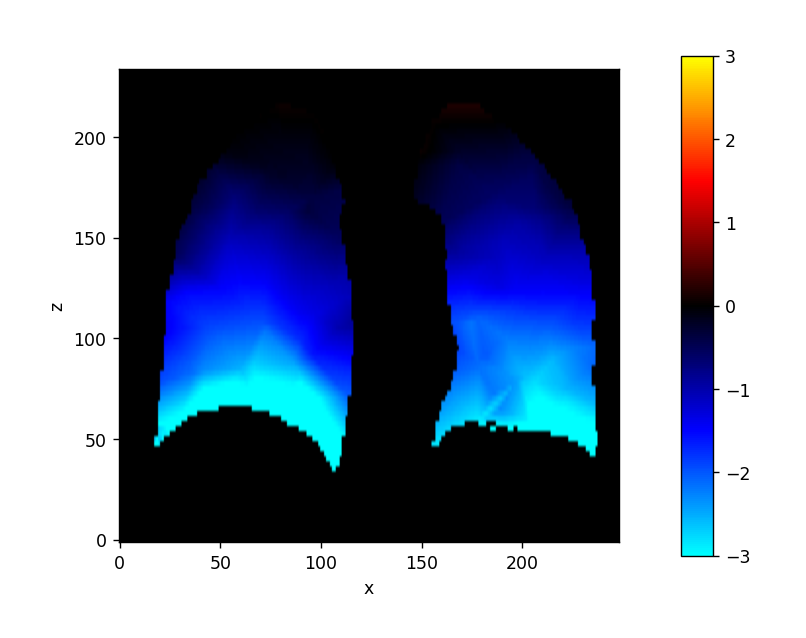

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


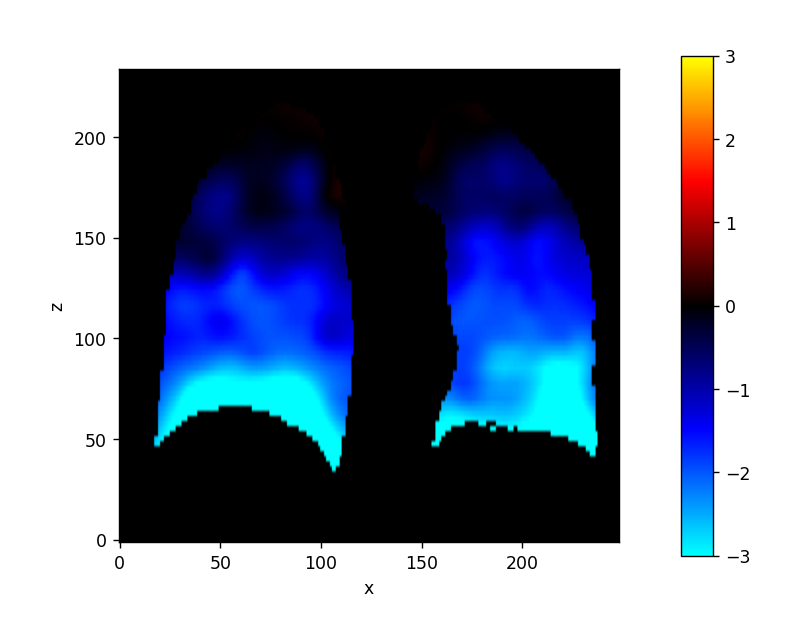

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


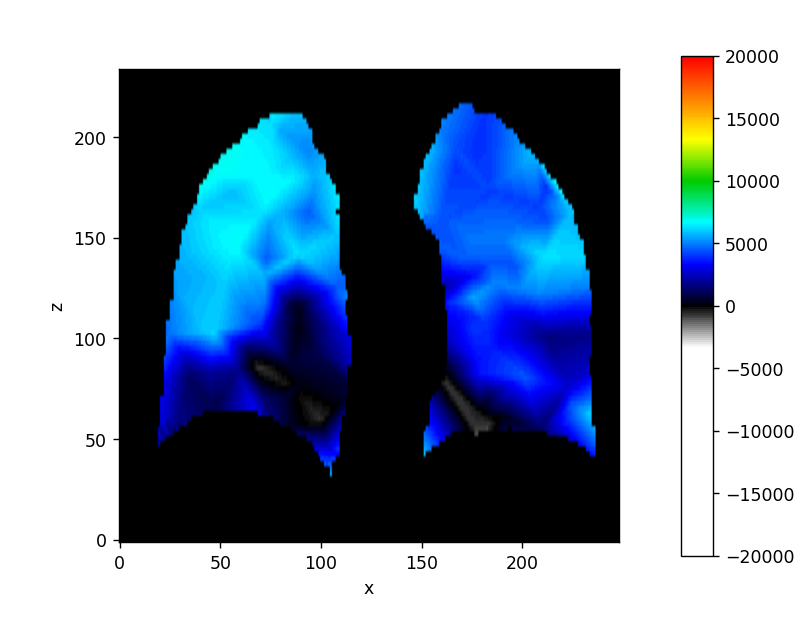

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [164]:
project.visual.XArrayViewer((reg_disp_image * 0 + u_pred_image) * ee_lung_mask, x='x', y='z', vmin=-3, vmax=3)
project.visual.XArrayViewer(reg_disp_image * ee_lung_mask, x='x', y='z', vmin=-3, vmax=3)
project.visual.view(mu_pred_image * ee_lung_mask, x='x', y='z', cmap=project.visual.mre_color_map(), vmin=-2e4, vmax=2e4)

In [ ]:
def estimate_limit(x, expand=0.1):
    x_min, x_max = np.min(x), np.max(x)
    x_range = (x_max - x_min)
    x_min -= expand * x_range / 2
    x_max += expand * x_range / 2
    return x_min, x_max

def plot_func(f):

    mesh = f.function_space().mesh()

    vertices = mesh.coordinates()
    n_vertices = mesh.num_vertices()
    values = f.compute_vertex_values(mesh)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d', aspect='equal')

    X = [vertices[:,i] for i in range(3)]
    U = [values[i * n_vertices:(i + 1) * n_vertices] for i in range(3)]
    
    print(np.mean(np.linalg.norm(U, axis=1), axis=0))
       
    args = X + U
    ax.quiver(*args)
    
    ax.set_xlim(estimate_limit(vertices.flatten()))
    ax.set_ylim(estimate_limit(vertices.flatten()))
    ax.set_zlim(estimate_limit(vertices.flatten()))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return fig, ax

plot_func(disp_fe_func)

In [ ]:
project.visual.view((reg_disp_image * 0 + sim_disp_image) * ee_lung_mask, x='x', y='z')